In [8]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from tqdm import tqdm
from sklearn import preprocessing
import talib

sys.path.append('../Runs')
from train_QTable import optimal_strategy, optimal_strategy_fixedStepsize, run
from train_fromSamples import train_BatchTree_fromSamples, train_Qtable_fromSamples
from helper.Q_learning import round_custombase
from helper.manage_orderbooks import OrderbookEpisodesGenerator, plot_episode
from helper.orderbook_trader import OrderbookTradingSimulator
from agents.QTable_Agent import QTable_Agent
from agents.BatchTree_Agent import RLAgent_BatchTree

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def load_and_preprocess_historyfiles(files):
    hist = pd.DataFrame()
    for file in histfiles:
        data = pd.read_csv(file, index_col=0)
        hist = pd.concat([hist, data])
    hist.set_index(keys=pd.to_datetime(hist.index), inplace=True)

    # remove dublicates and unneeded columns
    hist = hist[~hist.index.duplicated(keep='first')]
    hist.drop(["id", 'isFrozen'], axis=1, inplace=True)

    # fill gaps with last observation
    idx = pd.date_range(hist.index[0], hist.index[-1], freq="1min")
    hist = hist.sort_index().reindex(index=idx.sort_values(), method='ffill')
    
    # add more features
    hist['spread'] = hist.lowestAsk - hist.highestBid

    #market_features = hist.loc[ts_prev:ts, :]

    #for timeperiod in [10, 60]:
    #    featurename = "EMA{}".format(timeperiod)
    #    hist[featurename] = talib.EMA(
    #                                np.array(hist['last']),
    #                                timeperiod=timeperiod
    #                                ) / hist['last']
    for lookahead in [15, 30, 45]:
        hist["future{}".format(lookahead)] = (hist['last'].shift(-lookahead) / hist['last']) - 1.

    return hist

histfiles = [
    "../../../../data/history/history_2016-11_USDT_BTC.csv",
    "../../../../data/history/history_2017-02_USDT_BTC.csv",
]

hist = load_and_preprocess_historyfiles(files=histfiles)
hist['future15_disc'] = pd.cut(hist.future15, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['future30_disc'] = pd.cut(hist.future30, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['future45_disc'] = pd.cut(hist.future45, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
display(hist.iloc[1021:1025,:])

,baseVolume,high24hr,highestBid,last,low24hr,lowestAsk,percentChange,quoteVolume,spread,future15,future30,future45,future15_disc,future30_disc,future45_disc
2016-11-09 03:01:00,417050.045093,716.0,709.740242,709.740241,702.680396,711.419498,0.004009,586.622061,1.679256,0.002366,0.004593,0.013399,3.0,3.0,4.0
2016-11-09 03:02:00,417128.134302,716.0,709.768994,711.419498,702.680396,711.419498,0.006251,586.731342,1.650504,0.002019,0.003802,0.008926,3.0,3.0,4.0
2016-11-09 03:03:00,417086.272705,716.0,709.723616,711.419498,702.680396,711.419498,0.006251,586.672174,1.695882,0.002019,0.003802,0.010514,3.0,3.0,4.0
2016-11-09 03:04:00,417050.431869,716.0,710.000001,710.000000,702.680396,711.419498,0.003144,586.621473,1.419497,0.003122,0.005845,0.013099,3.0,4.0,4.0


In [4]:
data_feb = pickle.load( open( "cached_windows/tradingwindows_1702_USTD_BTC.p", "rb" ) )
print("loaded")
for window in tqdm(data_feb[:20]):
    for ob in window:
        ob.norm_factor = 1.
        ob.features = {'spread': ob.asks.index[0]-ob.bids.index[0]}
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        market_features = hist.loc[ts_prev:ts, :]
        
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]
            ob.features["future{}_disc".format(lookahead)] = market_features['future{}_disc'.format(lookahead)][-1]
display(len(data_feb), data_feb[0][0])

  5%|▌         | 1/20 [00:00<00:02,  7.78it/s]

loaded


100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


670

OrderbookContainer from 2017-02-01T00:00 (factor: 1.0)
  139 bids (best: 965.8666755)
  113 asks (best: 965.99)
price: 965.928336437291
  kind: 'orderbook'
  -spread: 0.12332449999996697
  -future15: 0.001425825042782991
  -future15_disc: 3.0
  -future30: 0.002989831786579078
  -future30_disc: 3.0
  -future45: 0.00272120465321124
  -future45_disc: 3.0

In [5]:
data_nov_orig = pickle.load( open( "cached_windows/tradingwindows_1611_USTD_BTC_20.p", "rb" ) )
for window in data_nov_orig:
    for ob in window:
        ob.norm_factor = 1.
        ob.features = {'spread': ob.asks.index[0]-ob.bids.index[0]}
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        market_features = hist.loc[ts_prev:ts, :]
        
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]
            ob.features["future{}_disc".format(lookahead)] = market_features['future{}_disc'.format(lookahead)][-1]
display(len(data_nov_orig), data_nov_orig[0][0])

20

OrderbookContainer from 2016-11-08T10:00 (factor: 1.0)
  107 bids (best: 705.0)
  110 asks (best: 705.450997)
price: 705.2254744655137
  kind: 'orderbook'
  -spread: 0.4509970000000294
  -future15: -3.246150348523713e-08
  -future15_disc: 2.0
  -future30: -0.0006393032568402512
  -future30_disc: 2.0
  -future45: -0.0025756666407984463
  -future45_disc: 1.0

In [6]:
data_nov = pickle.load( open( "cached_windows/tradingwindows_1611_USTD_BTC_20.p", "rb" ) )
for window in data_nov:
    center = window[0].get_center()

    for o, ob in enumerate(window):
        # ob.asks['norm'] = ob.asks.index / center
        new_idx = ob.asks.index / center
        ob.asks.index = new_idx

        ob.bids.set_index([ob.bids.index / center], inplace=True)
        ob.norm_factor = center
        ob.features = {'spread': ob.asks.index[0]-ob.bids.index[0]}
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        market_features = hist.loc[ts_prev:ts, :]
        
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]
            ob.features["future{}_disc".format(lookahead)] = market_features['future{}_disc'.format(lookahead)][-1]
        
print(len(data_nov))
display(data_nov[0][0])
#display(data_nov[17][0])

20


OrderbookContainer from 2016-11-08T10:00 (factor: 705.2254744655137)
  107 bids (best: 0.9996802803164696)
  110 asks (best: 1.000319787844671)
price: 0.9999999999997474
  kind: 'orderbook'
  -spread: 0.0006395075282014107
  -future15: -3.246150348523713e-08
  -future15_disc: 2.0
  -future30: -0.0006393032568402512
  -future30_disc: 2.0
  -future45: -0.0025756666407984463
  -future45_disc: 1.0

In [7]:
data_selection = [data_nov_orig[x] for x in [0,17]]
print(len(data_selection))
print(data_selection[0][0])
print(data_selection[1][0])

2
OrderbookContainer from 2016-11-08T10:00 (factor: 1.0)
  107 bids (best: 705.0)
  110 asks (best: 705.450997)
price: 705.2254744655137
  kind: 'orderbook'
  -spread: 0.4509970000000294
  -future15: -3.246150348523713e-08
  -future15_disc: 2.0
  -future30: -0.0006393032568402512
  -future30_disc: 2.0
  -future45: -0.0025756666407984463
  -future45_disc: 1.0
OrderbookContainer from 2016-11-09T03:01 (factor: 1.0)
  108 bids (best: 709.7402417)
  153 asks (best: 711.4194982)
price: 710.5795392453285
  kind: 'orderbook'
  -spread: 1.679256500000065
  -future15: 0.0023660177939859306
  -future15_disc: 3.0
  -future30: 0.004592889793137767
  -future30_disc: 3.0
  -future45: 0.013398928448407288
  -future45_disc: 4.0


In [ ]:
for idx in [0, 6, 17]:
    print("idx:", idx)
    plot_episode(data_nov[idx], volume=100, vlines=[0, 15, 30, 45])
    #plot_episode(data_nov_orig[idx], volume=100)
    print(data_nov[idx][0])


  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[0.0, 0.10000000000000001, 0.20000000000000001, 0.29999999999999999, 0.40000000000000002, 0.5, 0.59999999999999998, 0.69999999999999996, 0.80000000000000004, 0.90000000000000002, 1.0]
2
RL-Type: <class 'agents.QTable_Agent.QTable_Agent'>
time_left 1


lim_increments 0.705225474466




1it [00:12, 12.32s/it]
 25%|██▌       | 1/4 [00:12<00:36, 12.32s/it]
0it [00:00, ?it/s]


Saved agent: 'q.json'
Saved samples: 'q.csv'
time_left 2


lim_increments 0.705225474466






1it [00:12, 12.08s/it]
 50%|█████     | 2/4 [00:24<00:24, 12.25s/it]
0it [00:00, ?it/s]


Saved agent: 'q.json'
Saved samples: 'q.csv'
time_left 3


lim_increments 0.705225474466






1it [00:11, 11.48s/it]
 75%|███████▌  | 3/4 [00:35<00:12, 12.02s/it]
0it [00:00, ?it/s]


Saved agent: 'q.json'
Saved samples: 'q.csv'
time_left 4


lim_increments 0.705225474466






1it [00:11, 11.81s/it]
  0%|          | 0/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]


Saved agent: 'q.json'
Saved samples: 'q.csv'
RL-Type: <class 'agents.QTable_Agent.QTable_Agent'>
time_left 1


lim_increments 0.710579539245






1it [00:09,  9.08s/it]
 25%|██▌       | 1/4 [00:09<00:27,  9.09s/it]
0it [00:00, ?it/s]


Saved agent: 'q.json'
Saved samples: 'q.csv'
time_left 2


lim_increments 0.710579539245






1it [00:13, 13.28s/it]
 50%|█████     | 2/4 [00:22<00:20, 10.35s/it]
0it [00:00, ?it/s]


Saved agent: 'q.json'
Saved samples: 'q.csv'
time_left 3


lim_increments 0.710579539245






1it [00:13, 13.65s/it]
 75%|███████▌  | 3/4 [00:36<00:11, 11.34s/it]
0it [00:00, ?it/s]


Saved agent: 'q.json'
Saved samples: 'q.csv'
time_left 4


lim_increments 0.710579539245






1it [00:12, 12.55s/it]
  0%|          | 0/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]


Saved agent: 'q.json'
Saved samples: 'q.csv'
RL-Type: <class 'agents.QTable_Agent.QTable_Agent'>
time_left 1


lim_increments 0.705225474466






1it [00:13, 13.17s/it]


Saved agent: 'q.json'
Saved samples: 'q.csv'


lim_increments 0.710579539245






2it [00:22, 11.92s/it]
 25%|██▌       | 1/4 [00:22<01:06, 22.19s/it]
0it [00:00, ?it/s]


Saved agent: 'q.json'
Saved samples: 'q.csv'
time_left 2


lim_increments 0.705225474466






1it [00:11, 11.83s/it]


Saved agent: 'q.json'
Saved samples: 'q.csv'


lim_increments 0.710579539245






2it [00:24, 12.14s/it]
 50%|█████     | 2/4 [00:46<00:45, 22.94s/it]
0it [00:00, ?it/s]


Saved agent: 'q.json'
Saved samples: 'q.csv'
time_left 3


lim_increments 0.705225474466






1it [00:10, 10.28s/it]


Saved agent: 'q.json'
Saved samples: 'q.csv'


lim_increments 0.710579539245






2it [00:23, 11.17s/it]
 75%|███████▌  | 3/4 [01:10<00:23, 23.12s/it]
0it [00:00, ?it/s]


Saved agent: 'q.json'
Saved samples: 'q.csv'
time_left 4


lim_increments 0.705225474466






1it [00:10, 10.47s/it]


Saved agent: 'q.json'
Saved samples: 'q.csv'


lim_increments 0.710579539245






2it [00:24, 11.41s/it]
100%|██████████| 4/4 [01:34<00:00, 23.41s/it]


Saved agent: 'q.json'
Saved samples: 'q.csv'


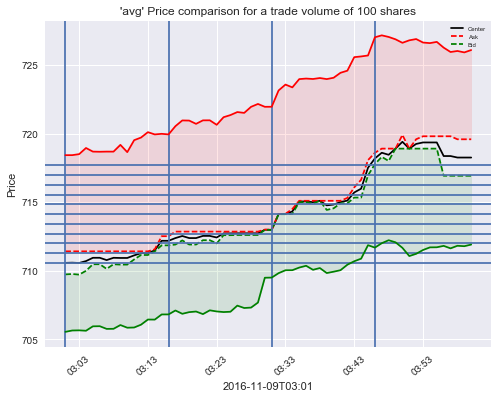

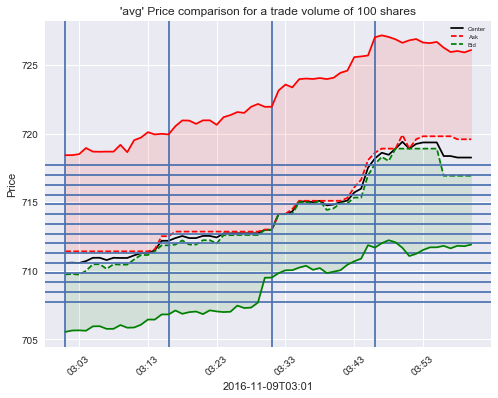

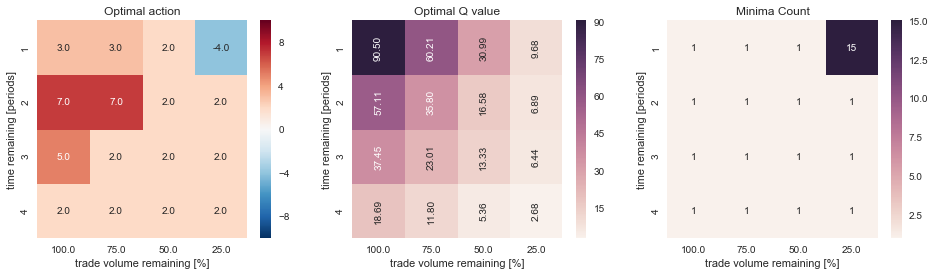

In [11]:
experiment_name='individual_window'
folder='experiments'
outputfile_agent=os.path.join(folder, experiment_name, 'model', experiment_name)
outputfile_agent='q.json'
outputfile_samples='q.csv'
volume=100
volume_intervals=4
decision_points=4
period_length=15
action_min=0
action_max=1
action_count=11
actions = list(round(a,1) for a in np.linspace(action_min, action_max, num=action_count))
print(actions)
state_variables=['volume','time']
limit_base = 'curr_ask' # 'curr_ask', 'init_center'

episodes_train = data_selection  # data_nov[17:18]
print(len(episodes_train))
#ql_even = optimal_strategy(traingdata=episodes_train[:1], V=volume, T=decision_points,
#                          period_length=period_length, vol_intervals=volume_intervals,
#                          actions=actions, state_variables=state_variables, 
#                          outfile_agent=outputfile_agent, outfile_samples=outputfile_samples,
#                          limit_base=limit_base)
#plot_episode(episodes_train[0], vlines=[0,15,30,45])
#ql_even.heatmap_Q(show_minima_count=True)

#ql_cresc, limits = optimal_strategy(traingdata=episodes_train[1:2], V=volume, T=decision_points,
#                          period_length=period_length, vol_intervals=volume_intervals,
#                          actions=actions,  state_variables=state_variables, 
#                          outfile_agent=outputfile_agent, outfile_samples=outputfile_samples,
#                          limit_base=limit_base)
ql_even, limits = optimal_strategy_fixedStepsize(traingdata=episodes_train[0:1], V=volume, T=decision_points,
                          period_length=period_length, vol_intervals=volume_intervals,
                          actions=list(range(-4,11)), lim_stepsize=0.1, state_variables=state_variables, 
                          outfile_agent=outputfile_agent, outfile_samples=outputfile_samples,
                          limit_base=limit_base)
ql_cresc, limits = optimal_strategy_fixedStepsize(traingdata=episodes_train[1:2], V=volume, T=decision_points,
                          period_length=period_length, vol_intervals=volume_intervals,
                          actions=list(range(-4,11)), lim_stepsize=0.1, state_variables=state_variables, 
                          outfile_agent=outputfile_agent, outfile_samples=outputfile_samples,
                          limit_base=limit_base)
ql, limits = optimal_strategy_fixedStepsize(traingdata=episodes_train[:], V=volume, T=decision_points,
                          period_length=period_length, vol_intervals=volume_intervals,
                          actions=list(range(-4,11)), lim_stepsize=0.1, state_variables=state_variables, 
                          outfile_agent=outputfile_agent, outfile_samples=outputfile_samples,
                          limit_base=limit_base)

hlines = [episodes_train[1][0].get_center() * (1. + (a/100.)) for a in actions]

plot_episode(episodes_train[1], vlines=[0,15,30,45], hlines=hlines)
hlines = [episodes_train[1][0].get_center() + (a*0.710579539245) for a in range(-4,11)]
plot_episode(episodes_train[1], vlines=[0,15,30,45], hlines=hlines)
ql_cresc.heatmap_Q(show_minima_count=True)

#ql = optimal_strategy(traingdata=episodes_train[:2], V=volume, T=decision_points,
#                          period_length=period_length, vol_intervals=volume_intervals,
#                          actions=actions, state_variables=state_variables, 
#                          outfile_agent=outputfile_agent, outfile_samples=outputfile_samples,
#                          limit_base=limit_base)
#ql.heatmap_Q(show_minima_count=True)

In [ ]:
plot_episode(episodes_train[1], vlines=[0,15,30,45], hlines=list(np.unique(limits)))

In [ ]:
plot_episode(episodes_train[1], vlines=[0,15,30,45], hlines=list(np.unique(limits)), limits=[episodes_train[1][0].get_center()*1.002])

both


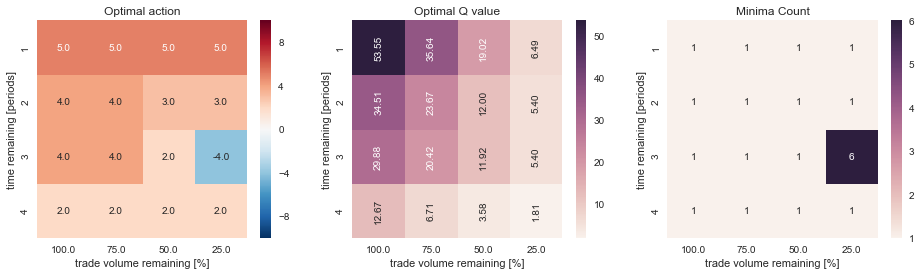

even


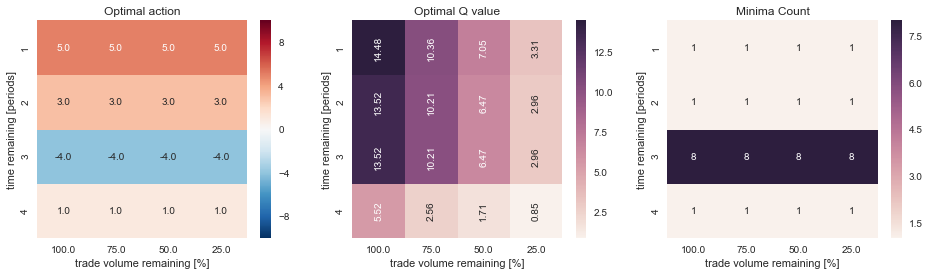

cresc


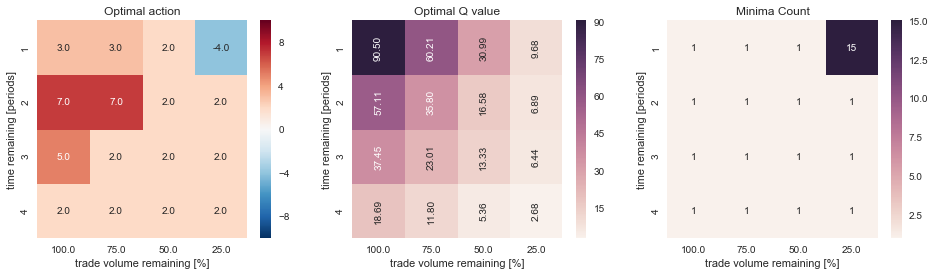

In [12]:
print("both")
ql.heatmap_Q(show_minima_count=True)
print("even")
ql_even.heatmap_Q(show_minima_count=True)
print("cresc")
ql_cresc.heatmap_Q(show_minima_count=True)



In [ ]:
agent_BatchTree['VolTime_20samples'].samples

0
2 1000 1.002
2 1002 1.004
3 1003 1.006
5 1010 1.015


'QTable_Agent'

'incStepUnits'

,ACTION,ASK,Aa_InitialMarketAvg,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cash,cost,forced,high,initialMarketAvg,low,volume_traded
2016-11-09T03:01,2,1.001182,1.011038,0.998819,1.000000,1.002,0.002363,15,100.000000,1.00118,-43.369833,4.631051,False,1.001389,1.011038,1.001182,43.318547
2016-11-09T03:16,2,1.002730,1.011038,1.001796,1.002263,1.004,0.000934,15,56.681453,1.00325,-12.617692,3.703208,False,1.003992,1.011038,1.002730,12.576828
2016-11-09T03:31,3,1.004077,1.011038,1.003376,1.003726,1.006,0.000702,15,44.104625,1.00503,-2.971675,1.347459,False,1.005939,1.011038,1.004077,2.956814
2016-11-09T03:46,5,1.011282,1.011038,1.010119,1.010700,1.015,0.001164,15,41.147811,1.01410,-41.728035,52.564134,False,1.014817,1.011038,1.011282,41.147811


1 1000 1.001
-4 1002 0.998
3 1003 1.006
5 1010 1.015


'ql_even'

'incStepUnits'

,ACTION,ASK,Aa_InitialMarketAvg,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cash,cost,forced,high,initialMarketAvg,low,volume_traded
2016-11-09T03:01,1,1.001182,1.011038,0.998819,1.000000,1.001,0.002363,15,100.000000,0.00000,0.000000,0.000000,False,0.000000,1.011038,inf,0.000000
2016-11-09T03:16,-4,1.002730,1.011038,1.001796,1.002263,0.998,0.000934,15,100.000000,0.00000,0.000000,0.000000,False,0.000000,1.011038,inf,0.000000
2016-11-09T03:31,3,1.003406,1.011038,1.003376,1.003391,1.006,0.000031,15,100.000000,1.00503,-2.973345,1.348218,False,1.005939,1.011038,1.003406,2.958478
2016-11-09T03:46,5,1.011282,1.011038,1.010119,1.010700,1.015,0.001164,15,97.041522,1.01526,-98.522770,134.163938,True,1.020734,1.011038,1.011282,97.041522


2 1000 1.002
2 1002 1.004
2 1003 1.005
2 1010 1.012


'ql_cresc'

'incStepUnits'

,ACTION,ASK,Aa_InitialMarketAvg,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cash,cost,forced,high,initialMarketAvg,low,volume_traded
2016-11-09T03:01,2,1.001182,1.011038,0.998819,1.000000,1.002,0.002363,15,100.000000,1.00118,-43.369833,4.631051,False,1.001389,1.011038,1.001182,43.318547
2016-11-09T03:16,2,1.002730,1.011038,1.001796,1.002263,1.004,0.000934,15,56.681453,1.00325,-12.617692,3.703208,False,1.003992,1.011038,1.002730,12.576828
2016-11-09T03:31,2,1.004077,1.011038,1.003376,1.003726,1.005,0.000702,15,44.104625,1.00478,-0.004539,0.001956,False,1.004954,1.011038,1.004077,0.004517
2016-11-09T03:46,2,1.011282,1.011038,1.010119,1.010700,1.012,0.001164,15,44.100108,1.01753,-44.873321,70.039854,True,1.020734,1.011038,1.011282,44.100108


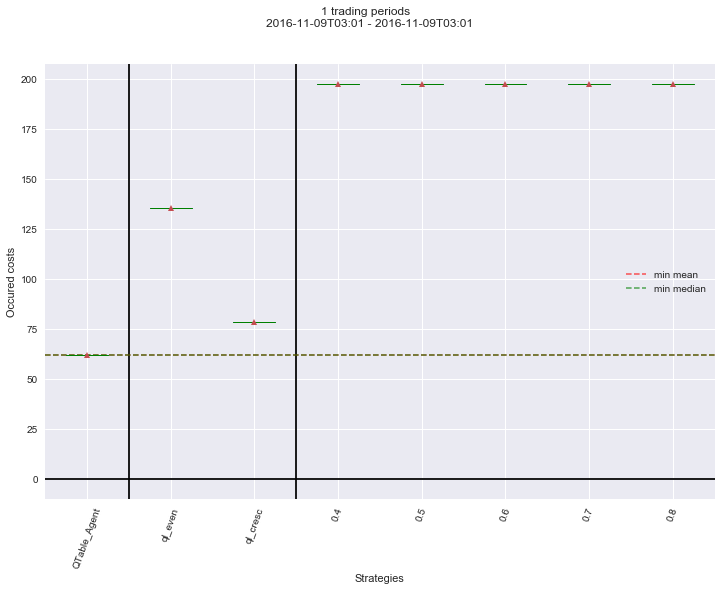

,QTable_Agent,ql_even,ql_cresc,0.4,0.5,0.6,0.7,0.8
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,62.245853,135.512156,78.376069,197.596538,197.596538,197.596538,197.596538,197.596538
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,62.245853,135.512156,78.376069,197.596538,197.596538,197.596538,197.596538,197.596538
25%,62.245853,135.512156,78.376069,197.596538,197.596538,197.596538,197.596538,197.596538
50%,62.245853,135.512156,78.376069,197.596538,197.596538,197.596538,197.596538,197.596538
75%,62.245853,135.512156,78.376069,197.596538,197.596538,197.596538,197.596538,197.596538
max,62.245853,135.512156,78.376069,197.596538,197.596538,197.596538,197.596538,197.596538
rel_mean,1.000000,2.177047,1.259137,3.174453,3.174453,3.174453,3.174453,3.174453
rel_median,1.000000,2.177047,1.259137,3.174453,3.174453,3.174453,3.174453,3.174453


,QTable_Agent,ql_even,ql_cresc,0.4,0.5,0.6,0.7,0.8
2016-11-09T03:01,62.245853,135.512156,78.376069,197.596538,197.596538,197.596538,197.596538,197.596538


,QTable_Agent,ql_even,ql_cresc,0.4,0.5,0.6,0.7,0.8
0,62.245853,135.512156,78.376069,197.596538,197.596538,197.596538,197.596538,197.596538


In [13]:
ql.limit_base = 'incStepUnits'
ql_even.limit_base = 'incStepUnits'
ql_cresc.limit_base = 'incStepUnits'
evaluation = ql.evaluate(data_nov[17:18],
                      additional_agents={
                          'ql_even': ql_even,
                          'ql_cresc':ql_cresc},
                      evaluate_actions=[0.4, 0.5, 0.6, 0.7, 0.8], verbose=True,
                      show_plot=True,
                      )
display(evaluation)
display(pd.DataFrame(evaluation.mean()).T)

In [ ]:
ql.volumes = ql.volumes[:4]
print(ql.volumes)

ql.heatmap_Q(vol_intervals=10)
ql.interpolate_vol = True
ql.heatmap_Q(vol_intervals=10)
ql.interpolate_vol = False

agent_BatchTree['VolTime_4I'].heatmap_Q()

In [ ]:
ql.interpolate_vol = True
evaluation = ql.evaluate(data_feb[:20],
                      additional_agents={
                          'rl_4I':agent_BatchTree['VolTime_4I'],
                          'rl_4I_3vars':agent_BatchTree['VolTime_4I_3vars']
                      },
                      evaluate_actions=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], verbose=False)
display(evaluation)
display(pd.DataFrame(evaluation.mean()).T)

In [ ]:
ql.interpolate_vol = False
evaluation = ql.evaluate(data_feb[:20],
                      additional_agents={
                          'rl_4I':agent_BatchTree['VolTime_4I'],
                          'rl_4I_3vars':agent_BatchTree['VolTime_4I_3vars']
                      },
                      evaluate_actions=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 
                      verbose=False)
#display(evaluation)
display(pd.DataFrame(evaluation.mean()).T)

In [ ]:
display((evaluation / 52.069724).mean())
ql.plot_evaluation_costs(evaluation.iloc[10:,:], hline='0.4', showfliers=False, ylim=(0,80))

In [ ]:
#df2 = ql.samples
actions = list(np.linspace(action_min, action_max, num=action_count))
actions = [round(a, 2) for a in actions]
print(actions)
state_variables = ['volume', 'time'] #, 'spread', 'high24hr', 'low24hr']

experiments = {
    'VolTime_4I': ['volume', 'time'],
    'VolTime_4I_3vars': ['volume', 'time', 'future15_disc'],
    # 'VolTimeSpread': ['volume', 'time', 'spread_disc'],
#    'VolTimeEMA': ['volume', 'time', 'EMA10', 'EMA60'],
    # 'VolTimeFuturedisc': ['volume', 'time', 'future15_disc', 'future30_disc', 'future45_disc']
    #'VolTimeFuturedisc15_20samples': ['volume', 'time', 'future15_disc']
}

#agent_BatchTree = {}
for i, key in enumerate(experiments.keys()):
    print("\n##### Experiment {}/{}: {} #####".format(i+1, len(experiments.keys()), key))
    state_variables_experiment = experiments[key]
    
    agent_BatchTree[key] = train_BatchTree_fromSamples(
        df=df2, V=volume, T=decision_points,
        period_length=period_length, vol_intervals=volume_intervals,
        actions=actions,
        state_variables=state_variables_experiment,
        n_estimators=100, max_depth=10
    )
    
    print("Feature importances:")
    print(agent_BatchTree[key].model.feature_importances_)

In [ ]:
plot_episode(data_nov_orig[0], kind='worst')
plot_episode(data_nov_orig[0], kind='avg')
plot_episode(data_nov_orig[17], kind='worst')
plot_episode(data_nov_orig[17], kind='avg')

# plot_episode(data_nov_orig[17], limits=[1.003992, 1.006207, 1.009890, np.nan], intervals=4, kind='worst')
# plot_episode(data_nov_orig[17], limits=[1.003992, 1.006207, 1.009890, np.nan], intervals=4, kind='avg')
# plot_episode(data_nov_orig[17], limits=[1.005], intervals=4)
# #plot_episode(data_nov[17], limits=[1.005, 1.005, 1.005, 1.005], intervals=4)

In [ ]:
ql17_60decisions.limit_base = 'init_center'
ql17_60decisions.heatmap_Q()
display(ql17_60decisions.evaluate(data_nov[17:18]))
ql17_60decisions.limit_base = 'curr_ask'
display(ql17_60decisions.evaluate(data_nov[17:18]))

ql17.heatmap_Q()
display(ql17.evaluate(data_nov[17:18]), limit_base='curr_ask')

In [ ]:
for val in ql17_spread.samples.spread.unique():
    print("{:1.6f}".format(val))

In [ ]:
agent = ql17
display(agent.samples.shape, agent.samples.iloc[302:315,:])
agent.heatmap_Q()

agent = ql17_
display(agent.samples.shape, agent.samples.iloc[302:315,:])
agent.heatmap_Q(show_minima_count=True)

agent = ql17_15decisions
display(agent.samples.shape, agent.samples.iloc[302:315,:])
agent.heatmap_Q(show_minima_count=True)

agent = ql17_60decisions
display(agent.samples.shape, agent.samples.iloc[302:315,:])
agent.heatmap_Q(show_minima_count=True)

In [ ]:
eval_costs = ql.evaluate(data_nov[17:18], additional_agents={'ql17_':ql17_, 'ql17_15decisions':ql17_15decisions}, show_plot=True)
display(eval_costs)
display(eval_costs.mean())

In [ ]:
def load_and_preprocess_historyfiles(files):
    hist = pd.DataFrame()
    for file in histfiles:
        data = pd.read_csv(file, index_col=0)
        hist = pd.concat([hist, data])
    hist.set_index(keys=pd.to_datetime(hist.index), inplace=True)

    # remove dublicates and unneeded columns
    hist = hist[~hist.index.duplicated(keep='first')]
    hist.drop(["id", 'isFrozen'], axis=1, inplace=True)

    # fill gaps with last observation
    idx = pd.date_range(hist.index[0], hist.index[-1], freq="1min")
    hist = hist.sort_index().reindex(index=idx.sort_values(), method='ffill')
    
    # add more features
    hist['spread'] = hist.lowestAsk - hist.highestBid

    for lookahead in [15, 30, 45]:
        hist["future{}".format(lookahead)] = (hist['last'].shift(-lookahead) / hist['last']) - 1

    return hist

histfiles = [
    "../../../../data/history/history_2016-11_USDT_BTC.csv",
    # "../../../../data/history/history_2016-12_USDT_BTC.csv",
    # "../../../../data/history/history_2017-01_USDT_BTC.csv",
    # "../../../../data/history/history_2017-02_USDT_BTC.csv"
]

hist = load_and_preprocess_historyfiles(files=histfiles)
display(hist.describe())
display(hist.head())

In [ ]:
state_variables = ['volume', 'time', 'spread', 'future15', 'future30', 'future45']
print("state_variables", state_variables)
# add features to orderbooks

for window in tqdm(data_nov):
    for ob_idx, ob in enumerate(window):
        ob.features = {}
        # queue.append(ob)
        # if len(queue) == period_length:
        #     
        #     diffs = list(map(lambda t: queue[t].compare_with(queue[t-1]), range(1,len(queue))))
        #     
        #     neg = np.array([d.asks[d.asks<0].sum() for d in diffs]).sum()
        #     pos = np.array([d.asks[d.asks>0].sum() for d in diffs]).sum()
        #     
        #     ob.features['act15neg'] = neg
        #     ob.features['act15pos'] = pos
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        
        
        market_features = hist.loc[ts_prev:ts, :]

       
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]
        
        for var in state_variables[2:]:
            ob.features[var] = market_features[var][-1]
            
print(data_nov[0][0])
print(data_nov[10][0])